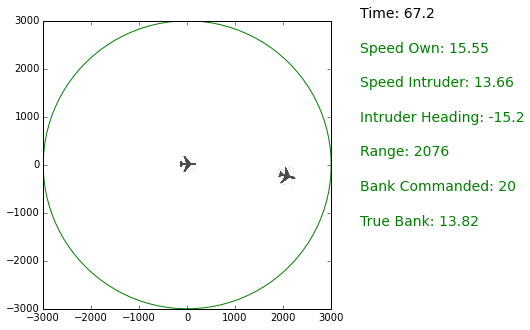

In [ ]:
%matplotlib inline
# coding: utf-8

# In[1]:

#get_ipython().magic(u'matplotlib inline')

from math import sin, cos, pi, tan
import scipy
from scipy import eye, matrix, random, asarray, ndimage
import pdb
from pybrain.rl.environments.graphical import GraphicalEnvironment
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
import keras
from matplotlib import pyplot as plt
from matplotlib.transforms import Affine2D
import matplotlib
import theano
import theano.tensor as T
import math
import h5py
import matplotlib.image as mpimg
import time
from IPython import display
import random
import sys



#Constants
DEFAULT_CAPACITY = 1500000#15000000
INIT_SIZE = 200000#1000000

SIGMA_ACT_CONFLICT     = 4.0/180.0*np.pi
SIGMA_ACT_NO_CONFLICT  = 10.0/180.0*np.pi
SIGMA_V                = 2.0

DT = 5
DTI = 0.1

LAMDA1 = 1
LAMDA2 = 0.0
LAMDA3 = 0.0002
LAMDA4 = 0.03

ACTIONS = np.array([-20.0/180.0*np.pi, -10.0/180.0*np.pi, 0.0, 10.0/180.0*np.pi, 20.0/180.0*np.pi, 1.0/180.0*np.pi])
COC = 1.0/180.0*np.pi

TRAIN_FREQ               = 200000#1000   
PRINT_FREQ               = 1000#10000    
TARGET_UPDATE_FREQ       = 15000#10000
SAVE_FREQ                = 2000


FINAL_EXPLORATION        = 0.1
FINAL_EXPLORATION_FRAME  = 7500000.0#750000000.0

BATCH_SIZE               = 2**9
K_SIZE                   = 1
GAMMA                    = 0.97

ICON_FILE = "AirplaneIcon.png"
RMAX = 3000.0
RMIN = 500.0
VMIN = 10.0
VMAX = 20.0
NUM_INPUTS = 5
NUM_ACTIONS = 6
SOLVER = 'adamax'

MEANS = np.array([1500.0,0.0,0.0,15.0,15.0])
RANGES = np.array([3000.0,2*np.pi,2*np.pi,10.0,10.0])
SIG_PARAM = 1.0/100.0

# In[41]:

class Plot_ACAS_XU(object):
    def __init__(self, maxSize, iconfile, iconSize):
        self.maxSize = maxSize
        self.icon= ndimage.imread(iconfile)
        self.iconSize = iconSize
        self.r = 0
        self.theta = 0
        self.psi = 0
        self.vOwn = 0
        self.vInt = 0
        self.action = 0
        self.actionCom = 0
        self.time = 0
        
        self.fig = plt.figure()
        self.axIntNum = 2
        ax = self.fig.add_axes([0, 0, 0.8, 1])
        axOwn   = self.fig.add_axes([0.4-0.03*self.iconSize, 
                               0.5-0.03*self.iconSize, 0.06*self.iconSize,0.06*self.iconSize])
        axInt = self.fig.add_axes([0.1,0.1,0.1,0.1])
        axText = self.fig.add_axes([0.8, 0.4, 0.3, 0.6])
        
        axOwn.imshow(self.icon)
        axOwn.set_xticks([])
        axOwn.set_yticks([])
        axOwn.axis('off')
        
        axInt.imshow(self.icon)
        axInt.set_xticks([])
        axInt.set_yticks([])
        axInt.axis('off')
        
        axText.set_xticks([])
        axText.set_yticks([])
        axText.axis('off')
        
        
        ax.set_xlim((-self.maxSize,self.maxSize))
        ax.set_ylim((-self.maxSize,self.maxSize))
        an = np.linspace(0, 2*np.pi, 100)
        ax.plot(self.maxSize*np.cos(an), self.maxSize*np.sin(an),'g') 
        ax.set_aspect('equal')
    def updateState(self,state,actionCom,action,dti):
        self.r = state[0]
        self.theta = state[1]
        self.psi = state[2]
        self.vOwn = state[3]
        self.vInt = state[4]
        self.action = action
        self.actionCom = actionCom
        self.time+=dti
        
    def draw(self):
        #self.fig.delaxes(self.fig.axes[2])
        x = self.r*math.cos(self.theta)
        y = self.r*math.sin(self.theta)   
        
        size = self.iconSize*(abs(np.sin(self.psi))+abs(np.cos(self.psi)))
        num = self.axIntNum
        self.fig.axes[num].set_position([x/self.maxSize/3.0+0.4-0.03*size, 
                               y/self.maxSize/2+0.5-0.03*size, 0.06*size,0.06*size])
        self.fig.axes[num].cla()
        self.fig.axes[num+1].cla()
        
        textTime ='Time: %.1f' % self.time
        textOwn = 'Speed Own: %.2f' % self.vOwn
        textInt = 'Speed Intruder: %.2f' % self.vInt
        textRange ='Range: %d' % self.r
        textAct = 'Bank Commanded: %d' % (self.actionCom*180/np.pi)
        textTrueAct = 'True Bank: %.2f' % (self.action*180/np.pi)
        textHeading = 'Intruder Heading: %.1f' % (self.psi*180/np.pi)
       
    
        self.fig.axes[num+1].text(0.0,1.0,textTime,
                                verticalalignment='bottom', horizontalalignment='left',
                                color='k',fontsize=14)
        
        self.fig.axes[num+1].text(0.0,0.8,textOwn,
                                verticalalignment='bottom', horizontalalignment='left',
                                color='g',fontsize=14)
        self.fig.axes[num+1].text(0.0,0.6,textInt,
                                verticalalignment='bottom', horizontalalignment='left',
                                color='g',fontsize=14)
        self.fig.axes[num+1].text(0.0,0.4,textHeading,
                                verticalalignment='bottom', horizontalalignment='left',
                                color='g',fontsize=14)
        self.fig.axes[num+1].text(0.0,0.2,textRange,
                                verticalalignment='bottom', horizontalalignment='left',
                                color='g',fontsize=14)
        
        self.fig.axes[num+1].text(0.0,0.0,textAct,
                                verticalalignment='bottom', horizontalalignment='left',
                                color='g',fontsize=14)
        
        self.fig.axes[num+1].text(0.0,-0.2,textTrueAct,
                                verticalalignment='bottom', horizontalalignment='left',
                                color='g',fontsize=14)
        
        dst = scipy.ndimage.rotate(self.icon,self.psi*180/np.pi, cval = 255)
        self.fig.axes[num].imshow(dst)
        
        self.fig.axes[num].set_xticks([])
        self.fig.axes[num].set_yticks([])
        self.fig.axes[num].axis('off')
        
        self.fig.axes[num+1].set_xticks([])
        self.fig.axes[num+1].set_yticks([])
        self.fig.axes[num+1].axis('off')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
        


# In[42]:

class StateGenerator(object):
    def __init__(self,rMax,rMin,speedMin,speedMax,K_SIZE):
        self.rMax = rMax
        self.rMin = rMin
        self.speedMin = speedMin
        self.speedMax = speedMax
        self.sigmaActConflict     = SIGMA_ACT_CONFLICT
        self.sigmaActNoConflict   = SIGMA_ACT_NO_CONFLICT
        self.sigmaV               = SIGMA_V
        self.size = K_SIZE
        
        self.lamda1 = LAMDA1
        self.lamda2 = LAMDA2
        self.lamda3 = LAMDA3
        self.lamda4 = LAMDA4
        self.COC = COC
        self.num_states = NUM_INPUTS
        self.means = MEANS
        self.ranges=RANGES
        self.SIG_PARAM = SIG_PARAM
        
        
    def getNextState(self,state,actionCom,dt,dti):
        r0 = state[0]
        th0 = state[1]
        psi0 = state[2]
        vown0 = state[3]
        vint0 = state[4]
        #if (self.size==1):
        #    nextStates = np.zeros(self.num_states)
        #    rewards = 0
        #else:
        nextStates = np.zeros((self.size,self.num_states))
        rewards = np.zeros(self.size)
        for j in range(self.size):
            #action,vown,vint = self.getTrueValues(actionCom,vownCom,vintCom)
            #if (vown>self.speedMax):
            #    vown = self.speedMax
            #if vown<self.speedMin:
            #    vown = self.speedMin
            #if (vint>self.speedMax):
            #    vint = self.speedMax
            #if vint<self.speedMin:
            #    vint = self.speedMin

            #print 'Action: %f' % (action*180.0/np.pi)

            i=0
            rMinimum = r0
            r = r0
            th = th0
            psi = psi0
            vown = vown0
            vint = vint0
            if dt!=dti:
                action,vown,vint = self.getTrueValues(actionCom,vown,vint)
            else:
                action = actionCom
            if (vown>self.speedMax):
                vown = self.speedMax
            if vown<self.speedMin:
                vown = self.speedMin
            if (vint>self.speedMax):
                vint = self.speedMax
            if vint<self.speedMin:
                vint = self.speedMin
            while i<dt:
                i+=dti

                
                

                x2 = r*math.cos(th) + vint*cos(psi)*dti
                y2 = r*math.sin(th) + vint*sin(psi)*dti
                x1 = vown*dti
                y1 = 0
                psi1 = 9.80*math.tan(action)/vown*dti
                psi = psi-psi1
                xabs = x2-x1
                yabs = y2-y1

                r= math.hypot(yabs,xabs)
                rMinimum = np.min([rMinimum,r])
                th = math.atan2(yabs,xabs) - psi1

                if (psi>math.pi):
                    psi-=2*math.pi
                elif (psi<-math.pi):
                    psi+=2*math.pi
            #if (self.size==1):
            #    nextStates[0] = r
            #    nextStates[1] = th
            #    nextStates[2] = psi
            #    nextStates[3] = vown
            #    nextStates[4] = vint
            #else:
            nextStates[j][0] = r
            nextStates[j][1] = th
            nextStates[j][2] = psi
            nextStates[j][3] = vown
            nextStates[j][4] = vint

            #Isep = 0
            Icoc = 0
            #if rMinimum<self.rMin:
            #    Isep = 1
            if actionCom!=self.COC:
                Icoc = 1
                
            #if (self.size==1):
                #rewards = -self.lamda1*Isep-self.lamda2*np.exp(-(rMinimum**2)/(self.rMin**2))-self.lamda3*(actionCom*180/np.pi)**2-self.lamda4*Icoc
            #    rewards = -self.lamda1/(1.0+np.exp(-(self.rMin-rMinimum)*self.SIG_PARAM))-self.lamda2*np.exp(-(rMinimum**2)/(self.rMin**2))-self.lamda3*(actionCom*180/np.pi)**2-self.lamda4*Icoc
            #else:
            rewards[j] = -self.lamda1/(1.0+np.exp(-(self.rMin-rMinimum)*self.SIG_PARAM))-self.lamda2*np.exp(-(rMinimum**2)/(self.rMin**2))-self.lamda3*(actionCom*180/np.pi)**2-self.lamda4*Icoc
                #rewards[j] = -self.lamda1*Isep-self.lamda2*np.exp(-(rMinimum**2)/(self.rMin**2))-self.lamda3*(actionCom*180/np.pi)**2-self.lamda4*Icoc
            
        return (nextStates,rewards)
    def randomStateGenerator(self):
        state = np.zeros(self.num_states)
        state[0] = abs(np.random.randn())/2*self.rMax + 200
        while (state[0]>self.rMax):
            state[0] = abs(np.random.randn())/2*self.rMax
        state[1] = (np.random.rand()-0.5)*2*np.pi
        state[2] = (np.random.rand()-0.5)*2*np.pi
        state[3] = np.random.rand()*(self.speedMax-self.speedMin)+self.speedMin
        state[4] = np.random.rand()*(self.speedMax-self.speedMin)+self.speedMin
        return state
   
    def checkRange(self,state):
        if state[0]>self.rMax:
            return True
        return False
    
    def getTrueValues(self,action,vown,vint):
        #num = np.random.rand()
        #if num<=4.0/13.0:
        #    return (action,vown,vint)
        #num = math.floor((num-4.0/13.0)/(1-4.0/13.0)*27)
 
        #actInd = int(num % 3) 
        #v1Ind = int((num%9)/3 )
        #v2Ind = int(num/9)
        #if action==0:
        #    return(action + self.sigmaActNoConflict[actInd],
        #           vown+self.sigmaV[v1Ind],
        #           vint+self.sigmaV[v2Ind])
        # 
        if action==self.COC:
            action=np.random.normal(action,self.sigmaActNoConflict,1)
        else:
            action = np.random.normal(action,self.sigmaActConflict,1)
        vown   = np.random.normal(vown,self.sigmaV,1)
        vint   = np.random.normal(vint,self.sigmaV,1)
        return (action,vown,vint)
    def normState(self,state,nextState):
        newState = np.zeros(state.shape)
        newNextState=np.zeros(nextState.shape)

        for i in range(5):
            newState[i] = (state[i]-self.means[i])/self.ranges[i]
            for j in range(K_SIZE):
                newNextState[j][i] = (nextState[j][i]-self.means[i])/self.ranges[i]
        return (newState,newNextState)
    def unNormState(self,state):
        newState = np.zeros(state.shape)
        for i in range(5):
            newState[i] = state[i]*self.ranges[i] + self.means[i]
        return newState
    #def getReward(self,(r,th,psi,vown,vint),action):
    #    Isep = 0
    #    Icoc = 0
    #    if r<self.rMin:
    #        Isep = 1
    #    if action!=0:
    #        Icoc = 1
    #    return -self.lamda1*Isep-self.lamda2*np.exp(-(r**2)/(self.rMin**2))-self.lamda3*action**2-self.lamda4*Icoc


# In[43]:

class ReplayMemory(object):

    def __init__(self, batch_size=BATCH_SIZE, init_size=INIT_SIZE, capacity=DEFAULT_CAPACITY):
        self.memory = {}
        self.batch_size = batch_size
        self.first_index = -1
        self.last_index = -1
        self.capacity = capacity
        self.init_size = init_size

    def store(self, sars_tuple):
        if self.first_index == -1:
            self.first_index = 0
        self.last_index += 1
        self.memory[self.last_index] = sars_tuple   
        if (self.last_index + 1 - self.first_index) > self.capacity:
            self.discard_sample()
    
    def canTrain(self):
        return self.last_index + 1 - self.first_index >=self.init_size

    def is_full(self):
        return self.last_index + 1 - self.first_index >= self.capacity

    def is_empty(self):
        return self.first_index == -1

    def discard_sample(self):
        rand_index = self.first_index#random.randint(self.first_index, self.last_index)
        #first_tuple = self.memory[self.first_index]
        del self.memory[rand_index]
        #if rand_index != self.first_index:
        #    del self.memory[self.first_index]
        #    self.memory[rand_index] = first_tuple
        self.first_index += 1

    def sample(self):
        if self.is_empty():
            raise Exception('Unable to sample from replay memory when empty')
        rand_sample_index = random.randint(self.first_index, self.last_index)
        return self.memory[rand_sample_index]

    def sample_batch(self):
        # must insert data into replay memory before sampling
        if not self.canTrain():
            return (-1,-1,-1,-1)
        if self.is_empty():
            raise Exception('Unable to sample from replay memory when empty')

        # determine shape of states
        states_shape = (self.batch_size,) + np.shape(self.memory.values()[0][0])
        rewards_shape = (self.batch_size*K_SIZE) #+ np.shape(self.memory.values()[0][2])
        nextStates_shape = (self.batch_size*K_SIZE,5)

        states = np.empty(states_shape)
        actions = np.empty((self.batch_size, 1))
        rewards = np.empty(rewards_shape)
        next_states = np.empty(nextStates_shape)

        # sample batch_size times from the memory
        for idx in range(self.batch_size):
            state, action, reward, next_state, = self.sample()
            states[idx] = state
            actions[idx] = action
            rewards[idx*K_SIZE:((idx+1)*K_SIZE)] = reward
            next_states[idx*K_SIZE:((idx+1)*K_SIZE)] = next_state

        return (states,actions,rewards,next_states)


# In[44]:

class QNetwork(object):

    def __init__(self, input_shape, batch_size, num_actions, discount, update_rule, rng=0):
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_actions = num_actions
        self.discount = discount
        self.update_rule = update_rule
        
        
        self.rng = rng if rng else np.random.RandomState()
        
        self.actions = ACTIONS
        self.saveFreq        = SAVE_FREQ
        self.replayStartSize = INIT_SIZE
        self.finalExploration = FINAL_EXPLORATION
        self.finalExplorationSize = FINAL_EXPLORATION_FRAME
        self.targetNetworkUpdateFrequency = TARGET_UPDATE_FREQ
        
        self.initialize_network()
        self.update_counter = 0
        self.counter = -1.0
        self.K_SIZE = K_SIZE
        self.COC = COC
    def getAction(self,state):
        self.counter+=1
        if self.counter < self.replayStartSize:
            return self.actions[self.rng.randint(self.num_actions)]     
        else:
            num = self.rng.rand()
            actInd=0
            if num>=np.min([(self.counter-self.replayStartSize),self.finalExplorationSize])/self.finalExplorationSize*(1-self.finalExploration):
                actInd = self.rng.randint(self.num_actions)
            else:
                actInd = np.argmax(self.model.predict(state.reshape(1,state.shape[0]),batch_size=1, verbose = 0))
            return self.actions[actInd]
    def initialize_network(self):
        
        def both(y_true, y_pred):
                    d = y_true-y_pred
                    #c = 0*d+0.01
                    #d = T.switch(abs(d)>0.01,c,d)
                    a = d**2
                    b = 0
                    l = T.switch(y_true<0,a,b)
                    cost1 = l#T.sum(l, axis=-1)

                    return cost1
        
        target = Sequential()

        target.add(Dense(128, input_dim=self.input_shape, init='uniform', activation='relu'))
        target.add(Dense(512, init='uniform', activation='relu'))
        target.add(Dense(512, init='uniform', activation='relu'))
        target.add(Dense(128, init='uniform', activation='relu'))
        target.add(Dense(128, init='uniform', activation='relu'))
        target.add(Dense(128, init='uniform', activation='relu'))
        target.add(Dense(self.num_actions, init='uniform'))

        target.compile(loss=both,optimizer=self.update_rule)

        

        model = Sequential()
        model.add(Dense(128, input_dim=self.input_shape, init='uniform', activation='relu'))
        model.add(Dense(512, init='uniform', activation='relu'))
        model.add(Dense(512, init='uniform', activation='relu'))
        model.add(Dense(128, init='uniform', activation='relu'))
        model.add(Dense(128, init='uniform', activation='relu'))
        model.add(Dense(128, init='uniform', activation='relu'))
        model.add(Dense(self.num_actions, init='uniform'))

        model.compile(loss=both,optimizer=self.update_rule)
        self.target = target
        self.model = model
        
    def train(self,(states,actions,rewards,next_states)):
        
        if np.size(states)==1:
            return
        if self.update_counter % self.saveFreq ==0:
            self.saveModel()
        if self.update_counter % self.targetNetworkUpdateFrequency==0:
            self.reset_target_network()
        self.update_counter+=1
                                             
        modelValues = np.zeros((np.size(actions),self.num_actions)) + 1.0
        #if (self.K_SIZE==1):
        #    q_target = self.target.predict(next_states,batch_size = 128) 
        #    for i in range(len(actions)):
        #        indTarget = np.argmax(q_target[i,:])
        #        indModel  = int(actions[i]*18.0/np.pi)+2
        #        if actions[i] == self.COC:
        #            indModel = 5
   
        #        modelValues[i,indModel] = rewards[i]+self.discount*q_target[i,indTarget]
        
        #else:
        q_target = self.target.predict(next_states,batch_size = 512)
        for i in range(len(actions)):
            q_target_temp = np.mean(q_target[i*K_SIZE:(i+1)*K_SIZE],axis=0)
            indTarget = np.argmax(q_target_temp)
            indModel  = int(actions[i]*18.0/np.pi)+2
            if actions[i] == self.COC:
                indModel = 5

            reward = np.mean(rewards[i*K_SIZE:(i+1)*K_SIZE])
            modelValues[i,indModel] = reward+self.discount*q_target_temp[indTarget]
                                             
                                             
        self.model.train_on_batch(states,modelValues)
    
    def reset_target_network(self):
        self.target.set_weights(self.model.get_weights())
        #target_weights = self.target.get_weights()
        #self.target.set_weights(self.model.get_weights())
        #self.model.set_weights(target_weights)
    
    def getModel(self):
        return self.model
    def getTarget(self):
        return self.target
    def saveModel(self):
        self.model.save_weights(("/home/sisl/kyle/data/DRL_LessReward2_%d.h5" % self.update_counter),overwrite=True)
        
    def test(self,(states,actions,rewards,next_states)):
        if np.size(states)==1:
            return -1
        
        #if (self.K_SIZE==1):
        #    q_target = self.target.predict(next_states,batch_size = 128)
        #    q_model  = self.model.predict(states,batch_size=128)
        #    loss = 0.0
        #    for i in range(len(q_model)):
        #        
        #        modelInd = int(actions[i]*18.0/np.pi)+2
        #        if actions[i] == self.COC:
        #            modelInd = 5;
        #        targetInd= np.argmax(q_target[i,:])
        #        loss += (q_model[i,modelInd]-rewards[i]-self.discount*q_target[i,targetInd])**2
        #else:
        q_model  = self.model.predict(states,batch_size=512)
        loss = 0.0
    #    for i in range(len(q_model)):
    #        q_target = self.target.predict(next_states[i],batch_size = self.K_SIZE)
    #        q_target = np.mean(q_target,axis=0)
    #        reward = np.mean(rewards[i])

    #        modelInd = int(actions[i]*18.0/np.pi)+2
    #        if actions[i] == self.COC:
    #            modelInd = 5;
    #        targetInd= np.argmax(q_target)
        q_target = self.target.predict(next_states,batch_size = 512)
        for i in range(len(actions)):
            indModel  = int(actions[i]*18.0/np.pi)+2
            if actions[i] == self.COC:
                indModel = 5

            reward = np.mean(rewards[i*K_SIZE:(i+1)*K_SIZE])
            q_target_temp = np.mean(q_target[i*K_SIZE:(i+1)*K_SIZE],axis=0)
            indTarget = np.argmax(q_target_temp)
            
            #print q_target_temp
            #print indTarget
            
            loss += (q_model[i,indModel]-reward-self.discount*q_target_temp[indTarget])**2
        return loss/len(q_model)
    


# In[45]:

#Initialize Qnetwork and repMem
draw = True
if draw:
    pltAcas = Plot_ACAS_XU(RMAX,ICON_FILE,1)
sg = StateGenerator(RMAX,RMIN,VMIN,VMAX,K_SIZE)
q = QNetwork(NUM_INPUTS,BATCH_SIZE,NUM_ACTIONS,GAMMA,SOLVER)
repMem = ReplayMemory()
count = 0

dt = DT
dti = DTI
state = sg.randomStateGenerator();
i = 0
while True:
    
    for j in range(TRAIN_FREQ):
        i+=1
        actionCom = q.getAction(state)
        action,vown,vint = sg.getTrueValues(actionCom,state[3],state[4])
        state[3] = vown
        state[4] = vint
        count2=0
        while count2<dt:
            count2+=dti
            nextStates,rewards = sg.getNextState(state,action,dti,dti)
            state = nextStates[0]
            count+=1
            if draw:
                pltAcas.updateState(state,actionCom,action,dti)
                pltAcas.draw()
                #time.sleep(dti)

            if sg.checkRange(state) or i>6:
                i=0
                state = sg.randomStateGenerator()
    if (count % PRINT_FREQ) ==0 and count>=INIT_SIZE:
        print "Samples: %d, Trainings: %d" % (count,(count-INIT_SIZE)/TRAIN_FREQ),"Loss: %.3e" % q.test(repMem.sample_batch())
        sys.stdout.flush()
    elif (count%10000==0):
        print"Samples: %d" % count
        sys.stdout.flush()
    q.train(repMem.sample_batch())

#pltAcas.updateState(state,action)
#pltAcas.draw()